In [1]:
%%time
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import transform

from shapely.geometry import Point, Polygon
import datetime

from io import StringIO
from pathlib import Path, PureWindowsPath
import os
import sys
from functools import partial

# Import custom functions from `scripts` folder
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from scripts.clean_tweets import geometrize_tweets, convert_shapefile_crs, find_frequencies
from scripts.home_location import assign_home_location
from scripts.summary_stats import summary_stats

data_path = Path("C:/Users/emman/Box/Twitter data/Hong Kong/")

Wall time: 918 ms


In [2]:
def filter_and_home_assign(data, shapefile, lower, upper):
    """
    Find subset of data to analyze based on lower/upper bounds on tweets/user, 
    then add home locations.
    
    Parameters
    ----------
    data : pd.DataFrame or gpd.GeoDataFrame
        DataFrame containing tweets; must contain column `u_id` for user id
    
    shapefile : gpd.GeoDataFrame
        Shapefile for tracts in tweets location.
        Must be in WGS84 (epsg:4326) format (to align with tweet lat/lon).
    
    lower, upper : int or float
        Lower (inclusive) and upper (exclusive) bounds on tweets/user.
        
    Returns
    -------
    filtered : gpd.GeoDataFrame
        Collection of tweets filtered by lower/upper and with tweet geographies.
        Contains new columns:
            - 'timestamp' : pd.Timestamp for time of tweet published
            - 'date' : date (int) of tweet published
            - 'hour' : 24-hour (int) of tweet published
            - 'home' : name of home location codigo (some may be NaN)
            - 'is_home' : boolean indicating whether tweet was made at home
    """
    # Filter based on lower and upper bound on tweets/user
    filtered = data.groupby('u_id').filter(lambda group: (len(group) >= lower) & (len(group) < upper))
    
    # Geometrize tweets (inplace) based on lat/lon
    filtered = geometrize_tweets(filtered)
    
    # Spatial join with tracts
    filtered = gpd.sjoin(filtered, shapefile, how='left', op='intersects')
    
    # Add datetime
    filtered['timestamp'] = pd.to_datetime(filtered['created_at'] // 1000, unit='s')
    filtered['date'] = filtered['timestamp'].dt.date
    filtered['hour'] = filtered['timestamp'].dt.hour
    
    # Add home location
    filtered['home'] = assign_home_location(filtered, SA2='SA2_MAIN16')
    filtered['is_home'] = filtered['SA2_MAIN16'] == filtered['home']
    
    return filtered

In [3]:
#read in the twitter data in box
hk_twitter = pd.read_csv('C:\\Users\\emman\\box\\Twitter data\\Asia\\Hong Kong\\hongkong.csv')

In [4]:
hk_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4122654 entries, 0 to 4122653
Data columns (total 13 columns):
 #   Column             Dtype  
---  ------             -----  
 0   id                 int64  
 1   created_at         float64
 2   text               object 
 3   u_id               int64  
 4   u_name             object 
 5   u_created_at       float64
 6   u_followers_count  int64  
 7   type               object 
 8   c_country          object 
 9   u_screen_name      object 
 10  u_friends_count    int64  
 11  location.lon       float64
 12  location.lat       float64
dtypes: float64(4), int64(4), object(5)
memory usage: 408.9+ MB


In [5]:
hk_twitter.rename(columns={'location.lon':'lon','location.lat':'lat'},inplace=True)

In [6]:
hk_gdf = gpd.read_file('C:\\Users\\emman\\box\\Twitter data\\Asia\\Hong Kong\\HK_2016_TPUs.geojson')

In [7]:
hk_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5034 entries, 0 to 5033
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   OBJECTID      5034 non-null   int64   
 1   PPU           5034 non-null   int64   
 2   SPU           5034 non-null   int64   
 3   TPU           5034 non-null   int64   
 4   SB_VC         5034 non-null   int64   
 5   TYPE_Eng      5034 non-null   object  
 6   TYPE_TC       5034 non-null   object  
 7   TYPE_SC       5034 non-null   object  
 8   Shape_Length  5034 non-null   float64 
 9   Shape_Area    5034 non-null   float64 
 10  geometry      5034 non-null   geometry
dtypes: float64(2), geometry(1), int64(5), object(3)
memory usage: 432.7+ KB


In [29]:
au_twitter.dropna(inplace=True)

In [5]:
au_twitter.head()

,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069
1,227395003947810817,1.343050e+12,Optus在strathfield附近的基站是不是出故障了，各种network lost...,22230298,McKay Wei ,1.235797e+12,I make things on the web. #SocialMediaEnthusia...,1023,ll,AUS,McKayWei,850,151.089056,-33.869059
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209


In [30]:
au_twitter.shape

(6450144, 14)

In [31]:
au_twitter['timestamp'] = pd.to_datetime(au_twitter['created_at'] // 1000, unit='s')
au_twitter['date'] = au_twitter['timestamp'].dt.date
au_twitter[['id', 'text', 'date','timestamp']].head()

,id,text,date,timestamp
0,227410653344841728,@DaintyAintMe one hyphenated word for you my l...,2012-07-23,2012-07-23 14:31:39
1,227395003947810817,Optus在strathfield附近的基站是不是出故障了，各种network lost...,2012-07-23,2012-07-23 13:29:28
2,227395554844483584,@heyfeebs nah it was at 2am... and hopefully n...,2012-07-23,2012-07-23 13:31:39
3,227397391727333376,@JUSECALO @AndreaSernaRCN si el apuntador dict...,2012-07-23,2012-07-23 13:38:57
4,227398082562768896,@nichteo1995 cause we didnt meet before I leav...,2012-07-23,2012-07-23 13:41:42


In [32]:
au_twitter['date'] = pd.to_datetime(au_twitter.date)

In [33]:
au_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6450144 entries, 0 to 7262132
Data columns (total 16 columns):
 #   Column             Dtype         
---  ------             -----         
 0   id                 int64         
 1   created_at         float64       
 2   text               object        
 3   u_id               int64         
 4   u_name             object        
 5   u_created_at       float64       
 6   u_description      object        
 7   u_followers_count  int64         
 8   type               object        
 9   c_country          object        
 10  u_screen_name      object        
 11  u_friends_count    int64         
 12  location.lon       float64       
 13  location.lat       float64       
 14  timestamp          datetime64[ns]
 15  date               datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(4), object(6)
memory usage: 836.6+ MB


Let's give those lat long a specific geometry as a point value for later geospatial plotting

In [34]:
# Create a shapely.geometry.Point for each tweet
geometry = [Point(xy) for xy in zip(au_twitter['location.lon'], au_twitter['location.lat'])]
crs = {'init' :'epsg:4326'}

In [35]:
# Convert to GeoDataFrame, where each tweet's geometry is assigned to the lat/lon coords
twt_gdf = gpd.GeoDataFrame(au_twitter, crs=crs, geometry=geometry)

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [36]:
print(twt_gdf.shape)
twt_gdf.head()

(6450144, 17)


,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,timestamp,date,geometry
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,2012-07-23 14:31:39,2012-07-23,POINT (151.21963 -33.87807)
1,227395003947810817,1.343050e+12,Optus在strathfield附近的基站是不是出故障了，各种network lost...,22230298,McKay Wei ,1.235797e+12,I make things on the web. #SocialMediaEnthusia...,1023,ll,AUS,McKayWei,850,151.089056,-33.869059,2012-07-23 13:29:28,2012-07-23,POINT (151.08906 -33.86906)
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,2012-07-23 13:31:39,2012-07-23,POINT (150.94787 -33.79827)
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,2012-07-23 13:38:57,2012-07-23,POINT (151.17801 -33.80927)
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,2012-07-23 13:41:42,2012-07-23,POINT (151.22299 -33.91221)


C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


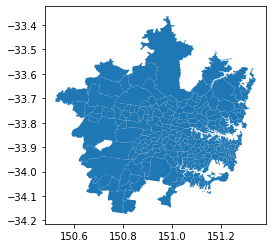

In [37]:
# Read Australia SA2 shapefiles
ucl_shape_sa2 = gpd.read_file('C:\\Users\\emman\\box\\Spring 2020\\Displacement Studio\\Shared 228 Sydney Folder\\SA2 Shapefiles\\sa2_ucl.dbf')
#Crikey, our area is too big
ucl_shape_sa2.plot()
# We also need to change the crs 
ucl_shape_sa2.crs = {'init': 'epsg:4326'}

KeyboardInterrupt: 

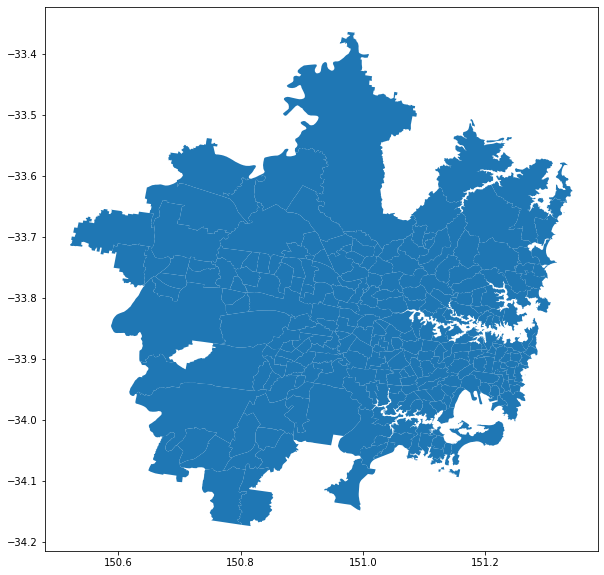

In [38]:
fig, ax = plt.subplots(figsize=(14, 10))
ucl_shape_sa2['geometry'].plot(ax=ax)
twt_gdf.plot(ax=ax, marker='o', color='red', alpha=0.05);

Hey, that's really stupid and uninformative. Maybe there's a better way?

In [39]:
ucl_shape_sa2.info()
ucl_shape_sa2.drop('Name',axis=1,inplace=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   SA2_MAIN16  265 non-null    object  
 1   SA2_5DIG16  265 non-null    object  
 2   SA2_NAME16  265 non-null    object  
 3   SA3_CODE16  265 non-null    object  
 4   SA3_NAME16  265 non-null    object  
 5   SA4_CODE16  265 non-null    object  
 6   SA4_NAME16  265 non-null    object  
 7   GCC_CODE16  265 non-null    object  
 8   GCC_NAME16  265 non-null    object  
 9   STE_CODE16  265 non-null    object  
 10  STE_NAME16  265 non-null    object  
 11  AREASQKM16  265 non-null    float64 
 12  Name        1 non-null      object  
 13  geometry    265 non-null    geometry
dtypes: float64(1), geometry(1), object(12)
memory usage: 29.1+ KB


In [40]:
ucl_shape_sa2.dropna(inplace=True)

In [41]:
twt_gdf_sub = twt_gdf[500:1000]

In [ ]:
figure, ax = plt.subplots(figsize=(14,10))
base = ucl_shape_sa2.plot(ax=ax)
twt_gdf_sub.plot(ax=base, markersize=1, color="Red")
lims=plt.axis("equal")
ax.set_axis_off()

ax.set_title('Tweets in Sydney UCL', fontdict= 
            {'fontsize':25})

plt.show()

This is still pretty stupid and uninformative, but at least it's a bit bigger! Maybe we can work on a spatial join so that we can get the tweets that fall just outside of Greater Sydney removed from our dataset

In [42]:
twtsa2_gdf = gpd.sjoin(twt_gdf,ucl_shape_sa2,how='left',op='within').copy()

In [43]:
twtsa2_gdf.dropna(inplace=True)

In [44]:
twtsa2_gdf.drop(['index_right','SA3_CODE16','SA3_NAME16','SA4_CODE16','SA4_NAME16','GCC_CODE16','GCC_NAME16',
                'STE_CODE16','STE_NAME16', 'geometry'],
                axis=1,
                inplace=True)
twtsa2_gdf.head()

,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,timestamp,date,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,AREASQKM16
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,2012-07-23 14:31:39,2012-07-23,117031329,11329,Darlinghurst,0.8569
1,227395003947810817,1.343050e+12,Optus在strathfield附近的基站是不是出故障了，各种network lost...,22230298,McKay Wei ,1.235797e+12,I make things on the web. #SocialMediaEnthusia...,1023,ll,AUS,McKayWei,850,151.089056,-33.869059,2012-07-23 13:29:28,2012-07-23,120031575,11575,Strathfield,6.4515
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,2012-07-23 13:31:39,2012-07-23,125041588,11588,Pendle Hill - Girraween,4.4615
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,2012-07-23 13:38:57,2012-07-23,121011399,11399,Chatswood (West) - Lane Cove North,5.5372
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,2012-07-23 13:41:42,2012-07-23,118021564,11564,Kensington (NSW),2.6422


In [49]:
twtsa2_gdf.rename(columns={'SA2_MAIN16':'tract_id','SA2_5DIG16':'tract_id_short','SA2_NAME16':'tract_name',
                          'location.lon':'longitude','location.lat':'latitude'}, inplace=True)

In [50]:
twtsa2_gdf.to_csv('C:\\Users\\emman\\desktop\\Sydney_UCL_Twitter.csv')

In [47]:
pd.read_csv('C:\\Users\\emman\\desktop\\Sydney_UCL_Twitter.csv')

,Unnamed: 0,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,timestamp,date,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,AREASQKM16
0,0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,2012-07-23 14:31:39,2012-07-23 00:00:00,117031329,11329,Darlinghurst,0.8569
1,1,227395003947810817,1.343050e+12,Optus在strathfield附近的基站是不是出故障了，各种network lost...,22230298,McKay Wei ,1.235797e+12,I make things on the web. #SocialMediaEnthusia...,1023,ll,AUS,McKayWei,850,151.089056,-33.869059,2012-07-23 13:29:28,2012-07-23 00:00:00,120031575,11575,Strathfield,6.4515
2,2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,2012-07-23 13:31:39,2012-07-23 00:00:00,125041588,11588,Pendle Hill - Girraween,4.4615
3,3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,2012-07-23 13:38:57,2012-07-23 00:00:00,121011399,11399,Chatswood (West) - Lane Cove North,5.5372
4,4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,2012-07-23 13:41:42,2012-07-23 00:00:00,118021564,11564,Kensington (NSW),2.6422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6043339,7262128,793342442187599873,1.477983e+12,bump bump 👌👌 (at @fitnfastgyms) — https://t.co...,310884150,Giovani,1.307198e+12,NPhotography,431,llp,AUS,NiniPhang,296,151.207890,-33.876530,2016-11-01 06:42:32,2016-11-01 00:00:00,117031337,11337,Sydney - Haymarket - The Rocks,4.2934
6043340,7262129,793316400756424704,1.477976e+12,"SBS 2, @sbs2 is now trending in Australia http...",211362581,Trends Australia,1.288748e+12,Real-time Australian Twitter trends.\nStart a ...,13738,llp,AUS,TrendsAustralia,3661,151.207000,-33.867100,2016-11-01 04:59:03,2016-11-01 00:00:00,117031337,11337,Sydney - Haymarket - The Rocks,4.2934
6043341,7262130,793326275314102272,1.477979e+12,"Mother Jones, @motherjones is now trending in ...",211362581,Trends Australia,1.288748e+12,Real-time Australian Twitter trends.\nStart a ...,13738,llp,AUS,TrendsAustralia,3661,151.207000,-33.867100,2016-11-01 05:38:17,2016-11-01 00:00:00,117031337,11337,Sydney - Haymarket - The Rocks,4.2934
6043342,7262131,793326882448150529,1.477979e+12,#GoodLooking #bastards @ Royal Randwick https:...,11922192,John Gakuru,1.199664e+12,Global booze hound!,2295,llp,AUS,johnniesworld,250,151.228963,-33.907359,2016-11-01 05:40:42,2016-11-01 00:00:00,118021570,11570,Randwick - South,3.3726


In [ ]:
# Select only users with greater than 20 tweets
df_20 = twtsa2_gdf.groupby('u_id').filter(lambda group: len(group) > 20)

print(df_20.shape)
df_20.head()

# Extract home location

## Ate's methodology for extracting home location:

1. Consider tracts satisfying the following properties:
 * More than 10 tweets total
 * Sent from more than 10 different days
 * Sent from more than 8 different hours of the day
2. Of the remaining candidates, select the tract with the most tweets



### 1a. More than 10 tweets total¶

Explanation of code below:

1. From our data
2. Group by user u_id and tract OBJECTID (assumed to be the tract ID)
3. Select only the user-tract combinations for which there are more than MIN_TWEETS tweets (i.e. for each user, select only the tracts with more than MIN_TWEETS tweets)

In [ ]:
df_sample = df_20[:100000]

In [ ]:
# This value should be adjusted when using the entire dataset
MIN_TWEETS = 2

output_1a = (
    df_sample # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .filter(lambda user_tract: len(user_tract) > MIN_TWEETS) # (3)
)

In [ ]:
print(output_1a.shape)
output_1a.head()

In [ ]:
# Sanity check
# Check documentation for asserthttps://www.tutorialspoint.com/python/assertions_in_python.htm
assert all(output_1a.groupby(['u_id', 'SA2_5DIG16']).size() > MIN_TWEETS)

## 1b. Sent from more than 10 days

In [ ]:
# First, some cleaning: extract timestamp from tweet data.
# Each tweet is recorded in UNIX time, and (for some reason) multiplied by 1000
output_1a['timestamp'] = pd.to_datetime(output_1a['created_at'] // 1000, unit='s')
output_1a['date'] = output_1a['timestamp'].dt.date

output_1a[['id', 'text', 'date','timestamp']].head()

Explanation of code below:

1. From our data
2. Group by user u_id and SA2 MAINCODE
3. Select user-SA2 combinations for which there are more than MIN_DAYS unique dates

In [ ]:
# This value should be adjusted when using the full dataset
MIN_DAYS = 2

output_1b = (
    output_1a # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .filter(lambda user_tract: user_tract['date'].nunique() > MIN_DAYS) # (3)
)

In [ ]:
print(output_1b.shape)
output_1b.head()

In [ ]:
# Sanity check
assert all(output_1b.groupby(['u_id', 'SA2_5DIG16'])['date'].nunique() > MIN_DAYS)

### 1c. Sent from more than 8 different hours of the day

In [ ]:
output_1b['hour'] = output_1b['timestamp'].dt.hour
output_1b[['id', 'text', 'hour']].head()

Explanation of code below:

1. From our data
2. Group by user u_id and SA2 MAINCODE
3. Select user-tract combinations for which there are more than MIN_HOURS unique hours

In [ ]:
# This value should be adjusted when using the full dataset
MIN_HOURS = 4

output_1c = (
    output_1b # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .filter(lambda user_tract: user_tract['hour'].nunique() > MIN_HOURS) # (3)
)

In [ ]:
print(output_1c.shape)
output_1c.head()

In [ ]:
# Sanity check
assert all(output_1c.groupby(['u_id', 'SA2_5DIG16'])['hour'].nunique() > MIN_HOURS)

## 2. Of the remaining candidates, select the tract with the most tweets

In [ ]:
# View number of tweets per user per tract
output_1c.groupby(['u_id', 'SA2_5DIG16']).size()

It looks to be the case that there are some users that have more than one tract satisfying all three constraints specified in 1a-1c. Thus for all users, we select the most frequent tract.

Explanation of code below:

1. From our data
2. Group by user u_id and tract SA2_5DIG16
3. Find the number of observations in each user-tract combination
4. Name the resulting pd.Series count, then convert into a pd.DataFrame
5. At this point, we have a DataFrame with each row representing one user-tract combination. There are three variables: u_id, SA2_5DIG16, and count (which represents the number of tweets recorded at the user-tract combination). Sort the rows in descending order by count, so that the first row that a given u_id appears corresponds to the SA2_5DIG16 for which it has the most tweets.
6. Select the u_id and OBJECTID columns in preparation for grouping.
7. Group by u_id so that each group represents a user, and each observation inside the group is an OBJECTID. The ordering should still stay consistent with step 5, i.e. the first observation in each group corresponds to the OBJECTID at which the user tweeted the most.
8. Select that first observation, to result in the DataFrame shown below
9. Rename column for convenience
10. Convert into pd.Series for convenience

In [ ]:
home_locations = (
    output_1c # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .size() # (3)
    .reset_index(name='count') # (4)
    .sort_values('count', ascending=False) # (5)
    .loc[:, ['u_id', 'SA2_5DIG16']] # (6)
    .groupby('u_id') # (7)
    .first() # (8)
    .rename(columns={'SA2_5DIG16':'home_sa2'}) # (9)
    .loc[:, 'home_sa2'] # (10)
)

In [ ]:
# Sanity check: We should have one home location for each unique user in output_1c 
assert len(home_locations) == output_1c['u_id'].nunique()

In [ ]:
# Assign each tweet a home_tract based on home_locations
# Using .map is orders of magnitudes faster than using a join
df_sample['home_sa2'] = df_sample['u_id'].map(home_locations.to_dict())

In [ ]:
# Preprocessing necessary for function
df_sample['timestamp'] = pd.to_datetime(df_sample['created_at'] // 1000, unit='s')
df_sample['date'] = df_sample['timestamp'].dt.date
df_sample['hour'] = df_sample['timestamp'].dt.hour
df_sample['SA2_5DIG16'].astype(str)

In [ ]:
df_sample['home_sa2'] = assign_home_location(df_sample, min_tweets=MIN_TWEETS, min_days=MIN_DAYS, min_hours=MIN_HOURS)
df_sample['home_sa2']

In [ ]:
df_sample['home_sa2'].isnull().sum()

About 20% of our sample data is not assigned a home location; this is because that user's tweets were all filtered out in part 1a-1c. It remains to be seen how this proportion may change for the entire set of data (as opposed to the sample of 100,000 observations).

# Running the full dataset through home location code:

In [ ]:
# This value should be adjusted when using the entire dataset
MIN_TWEETS = 2

output_1a = (
    twtsa2_gdf # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .filter(lambda user_tract: len(user_tract) > MIN_TWEETS) # (3)
)

In [ ]:
print(output_1a.shape)
output_1a.head()

In [ ]:
# Sanity check
# Check documentation for asserthttps://www.tutorialspoint.com/python/assertions_in_python.htm
assert all(output_1a.groupby(['u_id', 'SA2_5DIG16']).size() > MIN_TWEETS)

In [ ]:
# First, some cleaning: extract timestamp from tweet data.
# Each tweet is recorded in UNIX time, and (for some reason) multiplied by 1000
output_1a['timestamp'] = pd.to_datetime(output_1a['created_at'] // 1000, unit='s')
output_1a['date'] = output_1a['timestamp'].dt.date

output_1a[['id', 'text', 'date','timestamp']].head()

In [ ]:
# This value should be adjusted when using the full dataset
MIN_DAYS = 2

output_1b = (
    output_1a # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .filter(lambda user_tract: user_tract['date'].nunique() > MIN_DAYS) # (3)
)

In [ ]:
print(output_1b.shape)
output_1b.head()

In [ ]:
# Sanity check
assert all(output_1b.groupby(['u_id', 'SA2_5DIG16'])['date'].nunique() > MIN_DAYS)

In [ ]:
output_1b['hour'] = output_1b['timestamp'].dt.hour
output_1b[['id', 'text', 'hour']].head()

In [ ]:
# This value should be adjusted when using the full dataset
MIN_HOURS = 4

output_1c = (
    output_1b # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .filter(lambda user_tract: user_tract['hour'].nunique() > MIN_HOURS) # (3)
)

In [ ]:
print(output_1c.shape)
output_1c.head()

In [ ]:
# Sanity check
assert all(output_1c.groupby(['u_id', 'SA2_5DIG16'])['hour'].nunique() > MIN_HOURS)

In [ ]:
# View number of tweets per user per tract
output_1c.groupby(['u_id', 'SA2_5DIG16']).size()

In [ ]:
home_locations = (
    output_1c # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .size() # (3)
    .reset_index(name='count') # (4)
    .sort_values('count', ascending=False) # (5)
    .loc[:, ['u_id', 'SA2_5DIG16']] # (6)
    .groupby('u_id') # (7)
    .first() # (8)
    .rename(columns={'SA2_5DIG16':'home_sa2'}) # (9)
    .loc[:, 'home_sa2'] # (10)
)

In [ ]:
# Sanity check: We should have one home location for each unique user in output_1c 
assert len(home_locations) == output_1c['u_id'].nunique()

In [ ]:
# Assign each tweet a home_tract based on home_locations
# Using .map is orders of magnitudes faster than using a join
twtsa2_gdf['home_sa2'] = twtsa2_gdf['u_id'].map(home_locations.to_dict())

In [ ]:
# Preprocessing necessary for function
twtsa2_gdf['timestamp'] = pd.to_datetime(twtsa2_gdf['created_at'] // 1000, unit='s')
twtsa2_gdf['date'] = twtsa2_gdf['timestamp'].dt.date
twtsa2_gdf['hour'] = twtsa2_gdf['timestamp'].dt.hour
twtsa2_gdf['SA2_5DIG16']= twtsa2_gdf['SA2_5DIG16'].astype(str)

In [ ]:
twtsa2_gdf['home_sa2'] = assign_home_location(twtsa2_gdf, min_tweets=MIN_TWEETS, min_days=MIN_DAYS, min_hours=MIN_HOURS)
twtsa2_gdf['home_sa2']

In [ ]:
twtsa2_gdf['home_sa2'].isnull().sum()

In [ ]:
#twtsa2_gdf.to_file("au_twitter.geojson", driver='GeoJSON')

In [ ]:
#twtsa2_gdf.to_csv('au_twitter.csv')

In [ ]:
twtsa2_gdf.head()

In [ ]:
autwt_2012 = au_twitter.loc[(au_twitter.date>='2012-01-01')&(au_twitter.date<'2013-01-01')]
autwt_2013 = au_twitter.loc[(au_twitter.date>='2013-01-01')&(au_twitter.date<='2014-01-01')]
autwt_2014 = au_twitter.loc[(au_twitter.date>='2014-01-01')&(au_twitter.date<='2015-01-01')]
autwt_2015 = au_twitter.loc[(au_twitter.date>='2015-01-01')&(au_twitter.date<='2016-01-01')]
autwt_2016 = au_twitter.loc[(au_twitter.date>='2015-01-01')&(au_twitter.date<='2017-01-01')]

In [ ]:
save_path = Path("C:/Users/emman/Box/Spring 2020/Displacement Studio/Datasets/")

In [ ]:
autwt_2012.to_csv(save_path/'AUST_TWT_2012.csv')

In [ ]:
autwt_2013.to_csv(save_path/'AUST_TWT_2013.csv')

In [ ]:
autwt_2014.to_csv(save_path/'AUST_TWT_2014.csv')

In [ ]:
autwt_2015.to_csv(save_path/'AUST_TWT_2015.csv')

In [ ]:
autwt_2016.to_csv(save_path/'AUST_TWT_2016.csv')